In [108]:
from nilearn import plotting, image, masking
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# average functional runs

In [7]:
# merge and average dr outputs
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t Smith09_dmn_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG0*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/dr_tempreg_maps_zstat_files_to_standard_smooth/_scan_REST_run-0*/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_G-M_M-SDB_P-2/_spatial_map_PNAS_Smith09_rsn10_spatial_map_file_..cpac_templates..PNAS_Smith09_rsn10.nii.gz/_fwhm_4/_dr_tempreg_maps_zstat_files_to_standard_smooth_03/temp_reg_map_z_0003_antswarp_maths.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths Smith09_dmn_group_4d.nii.gz -Tmean Smith09_dmn_group_4d_mean

In [17]:
# merge and average functional scans
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t func_to_standard_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG0*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/mean_functional_to_standard/_scan_REST_run-*/sub-ULG*_ses-0_task-REST_run-0*_dir-AP_bold_calc_tshift_resample_volreg_calc_tstat_antswarp.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths func_to_standard_group_4d.nii.gz -Tmean func_to_standard_group_4d_mean


In [33]:
# merge and average t1 scans
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t anat_to_standard_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/anatomical_to_standard/transform_Warped.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths anat_to_standard_group_4d.nii.gz -Tmean anat_to_standard_group_mean


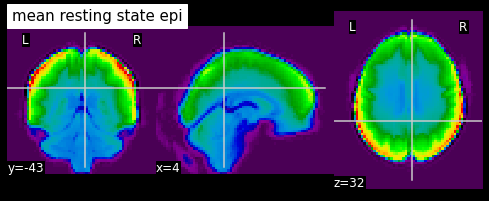

In [24]:
plotting.plot_epi('func_to_standard_group_4d_mean.nii.gz', title = 'mean resting state epi')

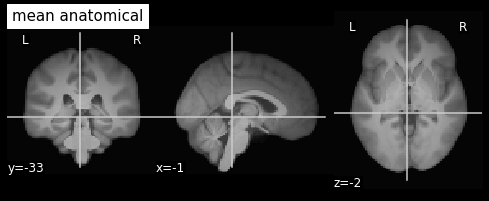

In [25]:
plotting.plot_anat(image.mean_img('anat_to_standard_group_4d.nii.gz'), title = 'mean anatomical')

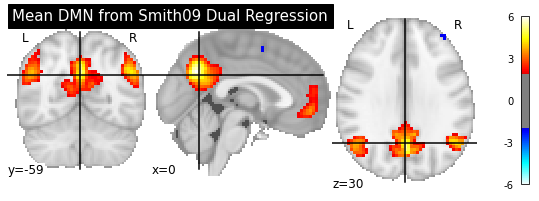

In [23]:
plotting.plot_stat_map('Smith09_dmn_group_4d_mean.nii.gz',
                       threshold=2,
                      title="Mean DMN from Smith09 Dual Regression",).savefig('Smith09_dmn_group_mean.png') 

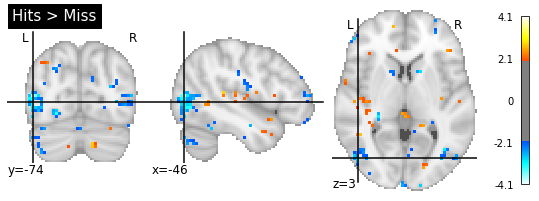

In [32]:
plotting.plot_stat_map('/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/MID/level3/noGSR/Flanker_Cope3_Level3/stats_dir/stats/zstat1.nii.gz',
                       threshold = 2,
                      title = 'Hits > Miss').savefig('mid.png') 

# ROI extraction from Inhibition contrast

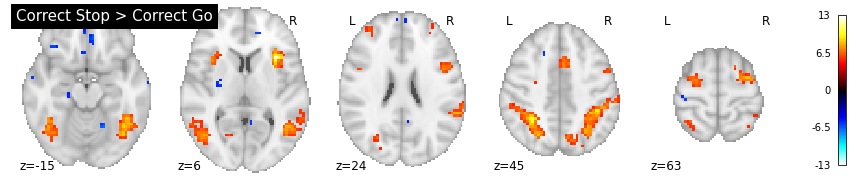

In [41]:
from nilearn.image import threshold_img
tmap = '/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/SST/corrstop_vs_correctgo/level3/noGSR/SST/Cope3_Level3/stats_dir/stats/tstat1_inverted.nii.gz'


threshold_percentile_img = threshold_img(tmap, threshold='99%', copy=False)
# Showing percentile threshold image
plotting.plot_stat_map(threshold_percentile_img, display_mode='z', title = 'Correct Stop > Correct Go', cut_coords=5)


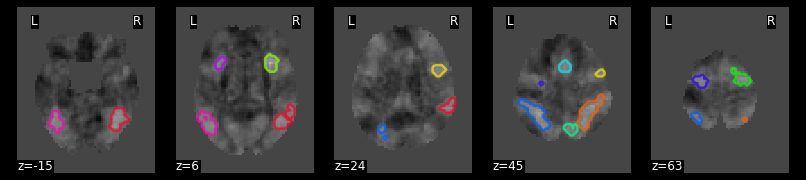

In [47]:
from nilearn.regions import connected_regions

regions_percentile_img, index = connected_regions(threshold_percentile_img,
                                                  min_region_size=1500, extract_type = 'connected_components')

plotting.plot_prob_atlas(regions_percentile_img, bg_img=tmap,
                         view_type='contours', display_mode='z',
                         cut_coords=5)


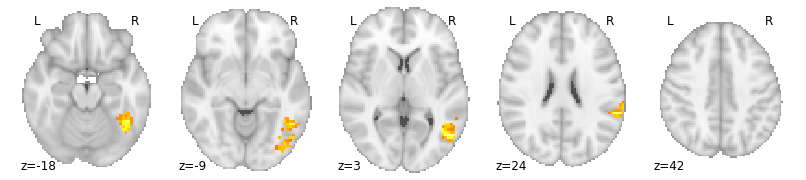

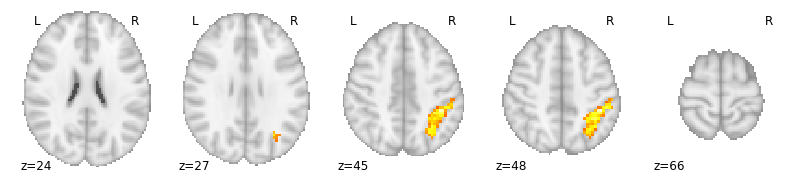

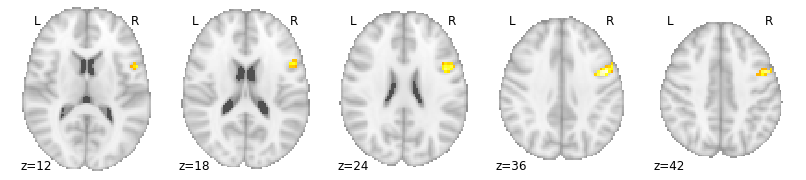

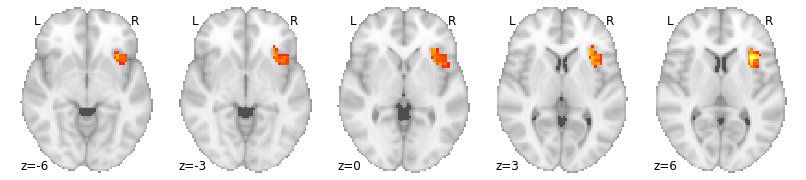

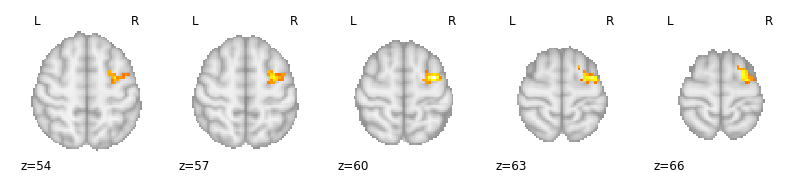

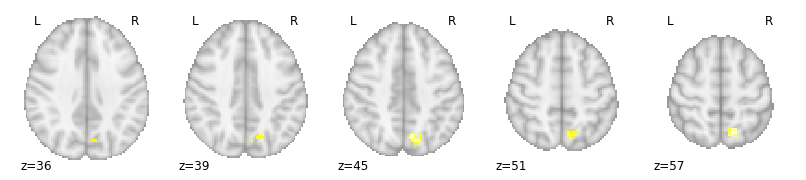

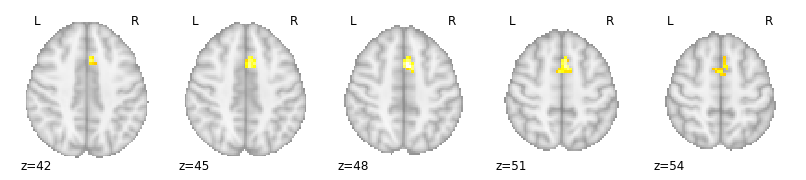

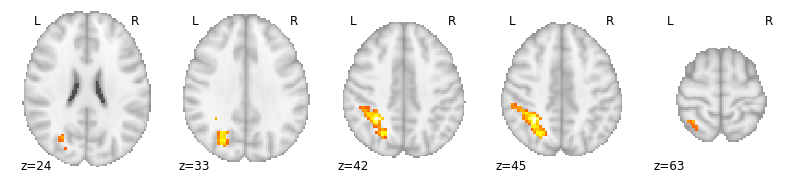

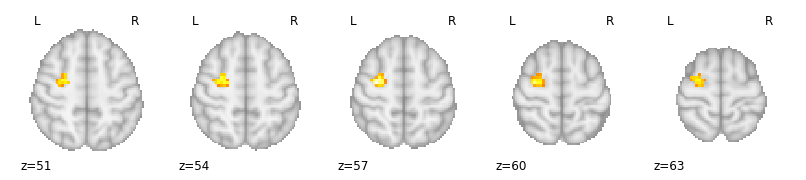

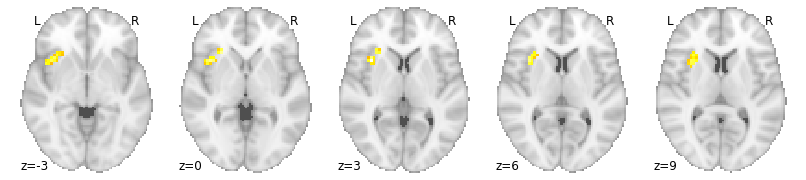

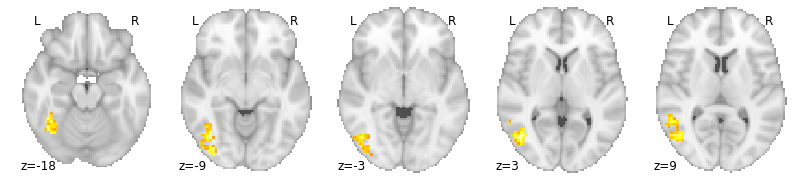

In [123]:
# visualize the connected regions separately
for img in image.iter_img(regions_percentile_img):

    plotting.plot_stat_map(img, threshold=3, display_mode="z", cut_coords=5,
                           colorbar=False)

In [49]:
#split regions_percentile_img into 3d 
regions_percentile_img.to_filename('regions_percentile_img.nii.gz')
! singularity exec /home/06028/tbweng/corral/singularity_images/fcpindi_c-pac_latest-1.6.0.sif fslsplit regions_percentile_img.nii.gz regions_percentile_img_

In [64]:
# extract L1 stat value from roi mask
! parallel --header : 'echo {stat} {roi} `singularity exec /home/06028/tbweng/corral/singularity_images/fcpindi_c-pac_latest-1.6.0.sif fslmeants -i {stat} -m {roi}`' \
::: roi `ls *000*.nii.gz` \
::: stat `find ~/corral/ULG/BIDS/derivatives/SST_031120/correctstop_vs_correctgo/L1/feat_dir/noGSR/run-*_sub-*_task-SST/run0.feat/stats -name 'zstat3.nii.gz'` \
> fslmeants_output.txt


In [91]:
df = pd.read_csv('fslmeants_output.txt', sep=" ", header=None)
df.columns = ["stat_file", "roi", "zstat"]

In [118]:
df['roi'] = df['roi'].str.split('_', expand = True)[3].str.split('.', expand = True)[0]

In [104]:
df['participant'] = df['stat_file'].str.split("/",expand=True)[13].str.split('_', expand = True)[1].str.split('-', expand = True)[1].str.strip('0')
df['run'] = df['stat_file'].str.split("/",expand=True)[13].str.split('_', expand = True)[0].str.split('0', expand = True)[1]

df['participant'] = df['participant'].astype(int)
df['run'] = df['run'].astype(int)

df.head()

,stat_file,roi,zstat,participant,run
0,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,regions_percentile_img_0000.nii.gz,-2.069169,3,1
1,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,regions_percentile_img_0000.nii.gz,-0.667781,12,1
2,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,regions_percentile_img_0000.nii.gz,-0.643983,1,1
3,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,regions_percentile_img_0000.nii.gz,-1.442300,1,1
4,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,regions_percentile_img_0000.nii.gz,-0.969637,4,1


In [99]:
df.dtypes

stat_file       object
roi             object
zstat          float64
participant      int64
run              int64
dtype: object

In [106]:
# load behavioral measure

ssrt = pd.read_csv('ssrt.csv')
ssrt['SSRT_demeaned'] = ssrt.SSRT - ssrt.SSRT.mean()

ssrt.head()


,participant,run,frameRate,meanSSD,median,SSRT,SSRT_demeaned
0,1,1,60,0.252941,0.536559,283.618204,-3.692167
1,1,2,60,0.278947,0.524916,245.968457,-41.341914
2,10,1,60,0.035484,0.354962,319.478265,32.167895
3,11,1,60,0.208824,0.421033,212.208981,-75.101390
4,11,2,60,0.193750,0.425839,232.088562,-55.221808


In [107]:
ssrt.dtypes

participant        int64
run                int64
frameRate          int64
meanSSD          float64
median           float64
SSRT             float64
SSRT_demeaned    float64
dtype: object

In [28]:
# correlate run1 vs run2 
ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[1].corr(ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[2])

0.3041979615603217

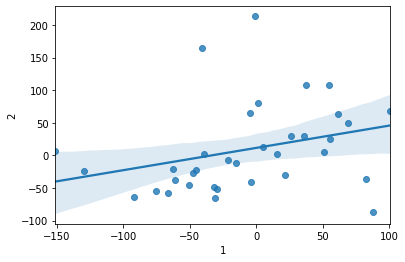

In [29]:
ax = sns.regplot(x = ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[1], y = ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[2])


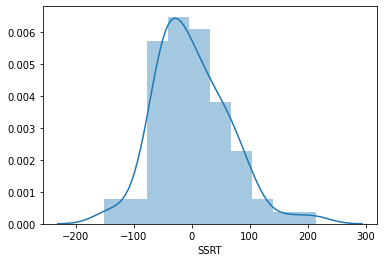

In [30]:
sns.distplot(ssrt.SSRT - ssrt.SSRT.mean())

In [120]:
# merge sst data with fslmeants data
ssrt_fslmeants = ssrt.merge(df, on = ['participant', 'run'])
ssrt_fslmeants.head()

,participant,run,frameRate,meanSSD,median,SSRT,SSRT_demeaned,stat_file,roi,zstat
0,1,1,60,0.252941,0.536559,283.618204,-3.692167,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,0000,-0.643983
1,1,1,60,0.252941,0.536559,283.618204,-3.692167,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,0000,-1.442300
2,1,1,60,0.252941,0.536559,283.618204,-3.692167,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,0001,-1.018385
3,1,1,60,0.252941,0.536559,283.618204,-3.692167,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,0001,-0.877015
4,1,1,60,0.252941,0.536559,283.618204,-3.692167,/home/06028/tbweng/corral/ULG/BIDS/derivatives...,0002,-1.550880


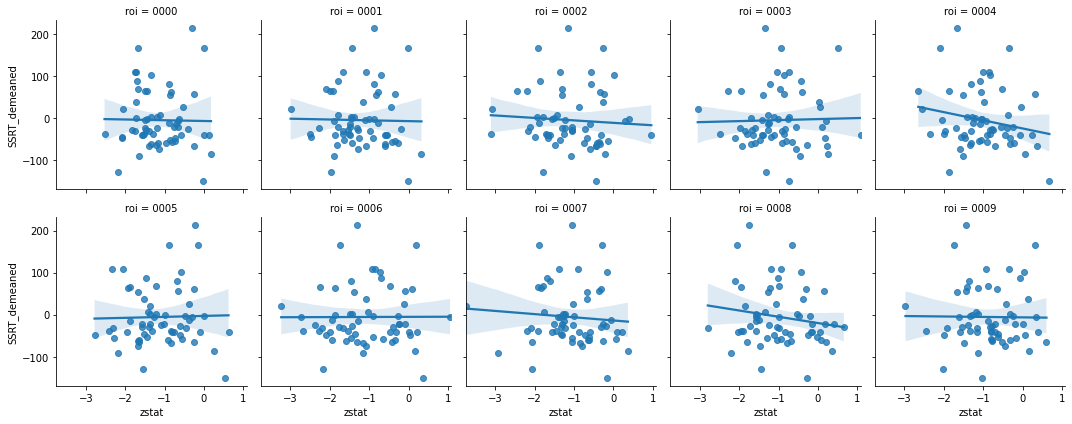

In [124]:
g = sns.lmplot(y="SSRT_demeaned", x="zstat", col="roi",
               data=ssrt_fslmeants, col_wrap=5, height=3)